# Parte 4: Cuantificación

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2024-07-30 05:07:34.987795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 05:07:35.119038: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Obtener el conjunto de datos de etiquetado de jets de Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Construir un modelo
Esta vez vamos a utilizar capas de QKeras.
QKeras es "Quantized Keras" para la cuantificación heterogénea profunda de modelos de ML.

https://github.com/google/qkeras

Está mantenido por Google y recientemente agregamos soporte para modelos de QKeras en hls4ml.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

Estamos utilizando la capa `QDense` en lugar de `Dense`, y `QActivation` en lugar de `Activation`. También estamos especificando `kernel_quantizer = quantized_bits(6,0,0)`. Esto utilizará 6 bits (de los cuales 0 son enteros) para los pesos. También usamos la misma cuantificación para los sesgos, y `quantized_relu(6)` para activaciones ReLU de 6 bits.

In [6]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(64,),
        name='fc1',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(
    QDense(
        2,
        name='output',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='softmax', name='softmax'))

## Entrenar con esparcidad
Volvamos a entrenar con esparcidad en el modelo, ya que las capas de QKeras son podables.

In [7]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Entrenar el modelo
Utilizaremos la misma configuración que el modelo de la parte 1: optimizador Adam con pérdida categórica de entropía cruzada.
Los callbacks disminuirán la tasa de aprendizaje y guardarán el modelo en un directorio llamado 'model_2'.
El modelo no es muy complejo, por lo que esto debería tomar solo unos minutos incluso en la CPU.
Si has reiniciado el kernel del cuaderno después de entrenar una vez, establece `train = False` para cargar el modelo entrenado en lugar de entrenar nuevamente.

In [8]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_3',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_3/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.6250
***callbacks***
saving losses to model_3/losses.log

Epoch 1: val_loss improved from inf to 0.79791, saving model to model_3/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.79791, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_3/KERAS_check_model_last.h5

Epoch 1: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

1/1 [==============================] - 2s 2s/step - loss: 0.7663 - accuracy: 0.6250 - val_loss: 0.7979 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.6250
***callbacks***
saving losses to model_3/losses.log

Epoch 2: val_loss improved from 0.79791 to 0.79736, saving model to model_3/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.79791 to 0.79736, saving model to model_3/KERAS_check_best_model_weights.h5

Ep

## Comprobar rendimiento
¿Cómo se compara este modelo, que fue entrenado usando 6 bits y 75% de esparcidad, con el modelo original? Informemos sobre la precisión y hagamos una curva ROC. El modelo cuantificado y podado se muestra con líneas sólidas, mientras que el modelo no podado de la parte 1 se muestra con líneas discontinuas.

También debemos verificar que hls4ml pueda respetar la elección de usar 6 bits en todo el modelo y que coincida con la precisión. Generaremos una configuración a partir de este modelo cuantificado, y graficaremos su rendimiento como la línea punteada.
La configuración generada se imprime. Notarás que utiliza 7 bits para el tipo, ¿pero especificamos 6? Eso se debe a que QKeras no cuenta el bit de signo cuando especificamos el número de bits, por lo que el tipo que realmente se utiliza necesita 1 más.

También utilizaremos el pase de optimización `OutputRoundingSaturationMode` de `hls4ml` para establecer las capas de activación en redondear, en lugar de truncar, el fundido. Esto es importante para obtener una buena precisión del modelo cuando se utilizan activaciones de precisión de bits pequeños. Y estableceremos un tipo de datos diferente para las tablas utilizadas en el Softmax, solo para un poco de rendimiento adicional.

**Asegúrate de haber entrenado el modelo de la parte 1**

In [9]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_3/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
np.save('model_3/y_qkeras.npy', y_qkeras)
np.save('model_3/y_hls.npy', y_hls)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Late

Done
1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 39ms/step
Accuracy baseline:  0.375
Accuracy pruned, quantized: 0.625
Accuracy hls4ml: 0.625


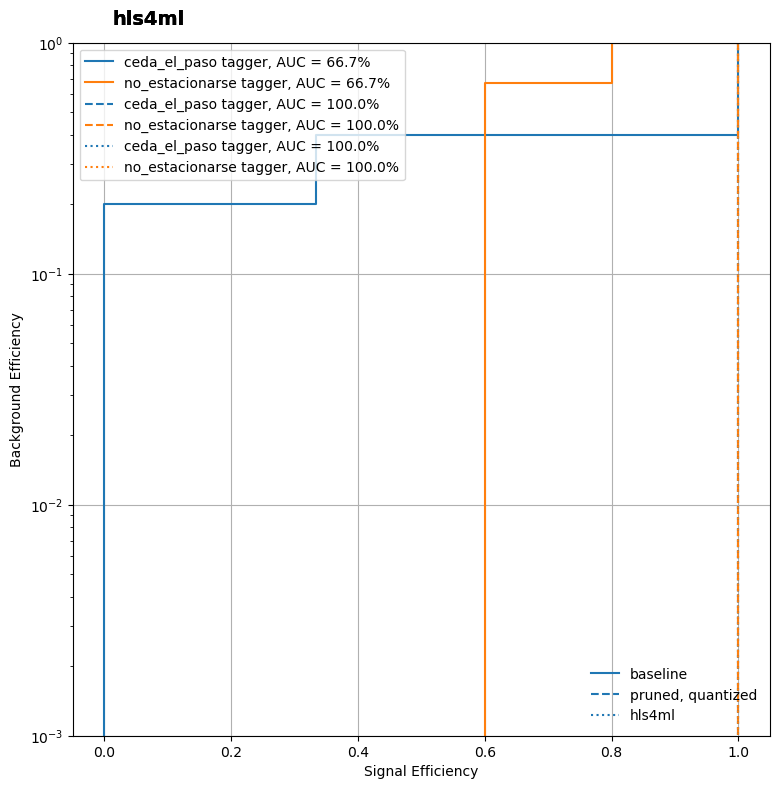

In [10]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Sintetizar
Ahora vamos a sintetizar este modelo cuantificado y podado.

**La síntesis llevará un tiempo**

Mientras se ejecuta la síntesis en C, podemos monitorear el progreso observando el archivo de registro abriendo un terminal desde el inicio del cuaderno y ejecutando:

`tail -f model_3/hls4ml_prj/vivado_hls.log`

In [11]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host 'c34b400bbab9' (Linux_x86_64 version 6.5.0-44-generic) on Tue Jul 30 05:12:53 UTC 2024
INFO: [HLS 200-10] In directory '/home/jovyan/HLS4ML/model_3/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/jovyan/HLS4ML/model_3/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200-10] Adding tes

{}

## Verificar los informes
Imprime los informes generados por Vivado HLS. Presta especial atención a la sección "Estimaciones de utilización" esta vez.

In [12]:
hls4ml.report.read_vivado_report('model_3/hls4ml_prj')

Found 1 solution(s) in model_3/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


Imprime el informe del modelo entrenado en la parte 1. Ahora, en comparación con el modelo de la parte 1, este modelo ha sido entrenado con cuantificación de baja precisión y un 75% de podado. Deberías poder ver que hemos ahorrado muchos recursos en comparación con donde comenzamos en la parte 1. Al mismo tiempo, consultando la curva ROC anterior, ¡el rendimiento del modelo es prácticamente idéntico incluso con esta compresión drástica!

**Nota que necesitas haber entrenado y sintetizado el modelo de la parte 1**

In [13]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


Imprime el informe del modelo entrenado en la parte 3. Ambos modelos fueron entrenados con un 75% de esparcidad, pero el nuevo modelo también utiliza una precisión de 6 bits. Puedes ver cómo Vivado HLS ha trasladado las operaciones de multiplicación de DSP a LUTs, reduciendo el uso de recursos "críticos".

**Nota que necesitas haber entrenado y sintetizado el modelo de la parte 3**

In [14]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj')

Found 1 solution(s) in model_2/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


## Nota
Ten en cuenta también que las estimaciones de recursos de Vivado HLS tienden a _sobreestimar_ las LUTs, mientras que generalmente estiman correctamente los DSPs. Ejecutar las etapas posteriores de compilación de FPGA revela el uso de recursos más realista. Puedes ejecutar el siguiente paso, 'síntesis lógica', con `hls_model.build(synth=True, vsynth=True)`, pero lo hemos omitido en este tutorial por razones de tiempo.